In [2]:
!pip install pycaret

     |████████████████████████████████| 261 kB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 14.2 MB 5.6 MB/s eta 0:00:01    |███▊                            | 1.7 MB 4.4 MB/s eta 0:00:03     |███████▋                        | 3.4 MB 4.4 MB/s eta 0:00:03     |█████████████████████           | 9.3 MB 4.5 MB/s eta 0:00:02
     |████████████████████████████████| 1.3 MB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 7.6 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 80 kB 6.6 MB/s eta 0:00:011
     |████████████████████████████████| 56 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 102 kB 8.3 MB/s eta 0:00:01
     |████████████████████████████████| 248 kB 7.7 MB/s eta 0:00:01
     |█████████████

In [1]:
import numpy as np
import pandas as pd
import os
import random
import pickle
from pycaret.classification import *
from pycaret.utils import check_metric
from datetime import timedelta, timezone, datetime
import torch
import time
from datetime import datetime

In [2]:
def setSeeds(seed = 42):
    # 랜덤 시드를 설정하여 매 코드를 실행할 때마다 동일한 결과를 얻게 합니다.
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)    
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
setSeeds(42)

In [3]:
def feature_split_user(df):
    new_df = df.copy()
    new_df["newUserID"] = df['assessmentItemID'].apply(lambda x:x[:3]) + df['userID'].astype(str)
    return new_df

def get_remain_test_data(df_test):
    get_new_id = set(df_test.loc[df_test.answerCode == -1, 'newUserID'])    
    test_data = df_test[df_test.newUserID.isin(get_new_id)]
    remain_data = df_test.drop(test_data.index)
    return test_data, remain_data
# time convert
def convert_time(s):
    timestamp = time.mktime(datetime.strptime(s, '%Y-%m-%d %H:%M:%S').timetuple())
    return int(timestamp)

In [4]:
train_path = '/opt/ml/input/data/train_dataset/train_data.csv'
test_path = '/opt/ml/input/data/train_dataset/test_data.csv'

df_train_ori = pd.read_csv(train_path) 
df_test_ori = pd.read_csv(test_path)

df_train = feature_split_user(df_train_ori)
df_test = feature_split_user(df_test_ori)

df_test_shift = df_test[df_test['userID'] != df_test['userID'].shift(-1)] # 맞춰야하는 row만 모아놓은 것
df_test, remain_data = get_remain_test_data(df_test)
df_train = pd.concat([df_train, remain_data])

df_train['Timestamp'] = df_train['Timestamp'].apply(convert_time)
df_test['Timestamp'] = df_test['Timestamp'].apply(convert_time)

df_train_test = pd.concat([df_train, df_test['answerCode'], df_test[df_test['answerCode'] != -1]])

In [5]:
# trian에서 각 문제 평균 뽑기
testId_mean_sum = df_train_test.groupby(['testId'])['answerCode'].agg(['mean','sum']).to_dict()
assessmentItemID_mean_sum = df_train_test.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum']).to_dict()
KnowledgeTag_mean_sum = df_train_test.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum']).to_dict()

In [150]:
# new user id 겹치는거 없음 확인
s1 = set(df_test.loc[:, 'newUserID'])
s2 = set(df_train.loc[:, 'newUserID'])
s1 & s2

set()

## Feature engineering
### 한번만 실행되도록 설정

In [6]:
def feature_engineering(df_ori):
    df = df_ori.copy()
    def assessmentItemID2item(x):
        return int(x[-3:]) - 1
    df['item'] = df.assessmentItemID.map(assessmentItemID2item)
    # testId별로 나오는 문제 갯수
    item_size = df[['assessmentItemID', 'testId']].drop_duplicates().groupby('testId').size()
    testId2maxlen = item_size.to_dict() # 중복해서 풀이할 놈들을 제거하기 위해
    
    item_max = df.groupby('testId')['item'].max()

    # 순서대로 풀지 않은 문제의 index
    not_order_index = item_max[item_max +1 != item_size].index    
    not_order_test = df.loc[df.testId.isin(not_order_index)][['assessmentItemID','testId']].drop_duplicates().sort_values('assessmentItemID')
    not_order_group = not_order_test.groupby('testId')

    not_order_ID2item = {}
    for key in not_order_group.groups:
        for i, (k, _) in enumerate(not_order_group.get_group(key).values):
            not_order_ID2item[k] = i
    
    def assessmentItemID2item_order(x):
        if x in not_order_ID2item:
            return int(not_order_ID2item[x])
        return int(x[-3:]) -1
    df['orded_item'] = df.assessmentItemID.map(assessmentItemID2item_order)
    df_group = df.groupby(['newUserID','testId'])['answerCode']
    #user 별 이전까지 맞춘개수, 현재까지 맞춘개수, 현재 정답률
    df['user_correct_answer'] = df_group.transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df_group.cumcount()
    df['user_acc'] = df['user_correct_answer'] / df['user_total_answer']
    
    #한 test안에서 마지막으로 푼 문제으로 부터 지난 시간
    df['prev_timestamp'] = df.groupby('testId')['Timestamp'].shift(0) - df.groupby('testId')['Timestamp'].shift(1)
    
    # user 별 마지막으로 푼 tag로부터 지난 시간, NaN값은 300으로 한다.
    prev_timestamp_ac = df.groupby(['newUserID', 'KnowledgeTag'])[['Timestamp']].shift()
    df['diff_time_btw_KnowledgeTag_ids'] = (df['Timestamp'] - prev_timestamp_ac['Timestamp']).fillna(300)
    
    # 각 tag 별 마지막으로 풀었을때 정답 여부
    prev_correct_ac = df.groupby(['newUserID', 'KnowledgeTag'])[['answerCode']].shift()        
    df['prev_answered_correctly'] = prev_correct_ac['answerCode'].fillna(0)
    
    #test, item, tag 별 평균 정답률
    df["test_mean"] = df.testId.map(testId_mean_sum['mean'])
    df["ItemID_mean"] = df.assessmentItemID.map(assessmentItemID_mean_sum['mean'])
    df["tag_mean"] = df.KnowledgeTag.map(KnowledgeTag_mean_sum['mean'])
    
    #test, Item, tag 별 상대적 정답률
    df['relative_test_answer'] = df['answerCode'] - df['test_mean']
    df['relative_ItemID_answer'] = df['answerCode'] - df['ItemID_mean']
    df['relative_tag_answer'] = df['answerCode'] - df['tag_mean']
    
    #이동평균선 5, 10, 15, 20, 25, 30
    df['ma5'] = df['user_acc'].fillna(0).rolling(window=5).mean()
    df['ma10'] = df['user_acc'].fillna(0).rolling(window=10).mean()
    df['ma15'] = df['user_acc'].fillna(0).rolling(window=15).mean()
    df['ma20'] = df['user_acc'].fillna(0).rolling(window=20).mean()
    df['ma25'] = df['user_acc'].fillna(0).rolling(window=25).mean()
    df['ma30'] = df['user_acc'].fillna(0).rolling(window=30).mean()
    
    #MACD
    df['MACD'] = df['ma15'] - df['ma25']
    
    #Standard Deviation 5,10, 15, 20, 25, 30
    df['sd5'] = df['user_acc'].fillna(0).rolling(window=5).std()
    df['sd10'] = df['user_acc'].fillna(0).rolling(window=10).std()
    df['sd15'] = df['user_acc'].fillna(0).rolling(window=15).std()
    df['sd20'] = df['user_acc'].fillna(0).rolling(window=20).std()
    df['sd25'] = df['user_acc'].fillna(0).rolling(window=25).std()
    df['sd30'] = df['user_acc'].fillna(0).rolling(window=30).std()
    
    #볼린저 밴드
    df['Upper BollingerBand'] = df['ma10'] + (df['sd10'] * 3)
    df['Lower BollingerBand'] = df['ma10'] - (df['sd10'] * 3)
    
    #이전에 같은 item, tag 몇 번 풀었는지
    df['prior_ItemID_frequency'] = df.groupby(['newUserID', 'assessmentItemID']).cumcount()
    df['prior_tag_frequency'] = df.groupby(['newUserID', 'KnowledgeTag']).cumcount()
    
    #망각 곡선TOD
    return df

In [7]:
if os.path.exists("fe_train.csv") and os.path.exists("fe_test.csv"):
    FE_train = pd.read_csv("fe_train.csv")
    FE_test = pd.read_csv("fe_test.csv")
    FE_train.drop('Unnamed: 0', axis=1, inplace=True)
    FE_test.drop('Unnamed: 0', axis=1, inplace=True)
    print("cache dataset complete")
else:
    print("working on feature engineering.")
    FE_train = feature_engineering(df_train)
    FE_test = feature_engineering(df_test)
    FE_train.to_csv('fe_train.csv')
    FE_test.to_csv('fe_test.csv')
    print("save dataset")

working on feature engineering.
save dataset


## catergorical data preprocessing

In [8]:
a = set(FE_train.assessmentItemID)
b = set(FE_test.assessmentItemID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(FE_train.testId)
b = set(FE_test.testId)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(FE_train.KnowledgeTag)
b = set(FE_test.KnowledgeTag)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(FE_train.newUserID)
b = set(FE_test.newUserID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

9454
9399
9399
**************************************************
1537
1526
1526
**************************************************
912
912
912
**************************************************
18995
744
0
**************************************************


In [9]:
from sklearn.preprocessing import LabelEncoder
# test data와 train data를 함께 handling하기 때문에 이전과 이후의 차이가 있는지 확인
def categori_preprocessing(PP_train, PP_test):
    cate_cols = ['newUserID', 'assessmentItemID', 'testId', 'KnowledgeTag']  # 문항, 시험지, 문항 태그
    PP_full = pd.concat([PP_train, PP_test])
    
    print("처리 시작")
    for col in cate_cols:
        label_encoder = LabelEncoder()
        #For UNKNOWN class
        a = PP_full[col].unique().tolist() + ['unknown']
        label_encoder.fit(a)

        #모든 컬럼이 범주형이라고 가정
        PP_full[col] = PP_full[col].astype(str)
        test = label_encoder.transform(PP_full[col])
        PP_full[col] = test
        PP_full[col] = PP_full[col].astype('category')
        print(col + "처리")
        
    return PP_full[:len(PP_train)], PP_full[len(PP_train):]

PP_train, PP_test = categori_preprocessing(FE_train, FE_test)

처리 시작
newUserID처리
assessmentItemID처리
testId처리
KnowledgeTag처리


In [10]:
a = set(PP_train.assessmentItemID)
b = set(PP_test.assessmentItemID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(PP_train.testId)
b = set(PP_test.testId)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(PP_train.KnowledgeTag)
b = set(PP_test.KnowledgeTag)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

a = set(PP_train.newUserID)
b = set(PP_test.newUserID)
print(len(a))
print(len(b))
print(len(a & b))
print('*' * 50)

9454
9399
9399
**************************************************
1537
1526
1526
**************************************************
912
912
912
**************************************************
18995
744
0
**************************************************


In [11]:
# 문제 없다면 다시 train test로 분배!
df_train, df_test = PP_train, PP_test
df_train.sample(5)
df_test.sample(5)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,newUserID,item,orded_item,user_correct_answer,user_total_answer,user_acc,prev_timestamp,diff_time_btw_KnowledgeTag_ids,prev_answered_correctly,test_mean,ItemID_mean,tag_mean,relative_test_answer,relative_ItemID_answer,relative_tag_answer,ma5,ma10,ma15,ma20,ma25,ma30,MACD,sd5,sd10,sd15,sd20,sd25,sd30,Upper BollingerBand,Lower BollingerBand,prior_ItemID_frequency,prior_tag_frequency
114737,1557,3937,753,1,1603085546,227,7730,4,4,3.0,4,0.75,56.0,56.0,1.0,0.707805,0.662207,0.727135,0.292195,0.337793,0.272865,0.583333,0.483333,0.533333,0.558333,0.583333,0.563889,-0.050000,0.372678,0.361752,0.372412,0.374732,0.376540,0.370541,1.568588,-0.601921,0,4
63343,792,5797,1044,0,1588749812,881,15352,4,4,4.0,4,1.00,6.0,6.0,1.0,0.772000,0.744000,0.741250,-0.772000,-0.744000,-0.741250,0.800000,0.498333,0.373333,0.305000,0.295333,0.361667,0.078000,0.447214,0.453413,0.411723,0.379908,0.346761,0.381772,1.858572,-0.861906,0,3
44530,568,7306,1249,0,1597981658,795,16796,4,4,3.0,4,0.75,64.0,300.0,0.0,0.474000,0.544000,0.494222,-0.474000,-0.544000,-0.494222,0.383333,0.660714,0.645238,0.595595,0.614095,0.678413,0.031143,0.361325,0.383065,0.379627,0.339431,0.344452,0.345815,1.809909,-0.488481,0,0
223849,3789,8370,1389,0,1597287437,290,18093,5,5,1.0,5,0.20,6.0,300.0,0.0,0.492188,0.522500,0.515556,-0.492188,-0.522500,-0.515556,0.456667,0.456190,0.448571,0.336429,0.328476,0.299048,0.120095,0.324380,0.286490,0.326888,0.344165,0.316256,0.297440,1.315660,-0.403279,0,0
10579,79,7555,1281,1,1599698536,884,17234,4,4,3.0,4,0.75,40.0,40.0,1.0,0.462667,0.464000,0.494326,0.537333,0.536000,0.505674,0.383333,0.691667,0.697619,0.773214,0.758190,0.765159,-0.060571,0.361325,0.404546,0.392929,0.363056,0.362825,0.369841,1.905304,-0.521971,0,4


# validation split

In [12]:
# 맞춰야하는 문항 ID 파악
set_assessmentItemID = set(df_test.loc[df_test.answerCode == -1, 'assessmentItemID'].values) # 문제별 ID
set_testId = set(df_test.loc[df_test.answerCode == -1, 'testId'].values) # 시험지별 ID
set_tag = set(df_test.loc[df_test.answerCode == -1, 'KnowledgeTag'].values) # 시험지별 ID

In [13]:
def get_full_valid_split(df_ori, filter_option=None):
    random.seed(0)
    df = df_ori.copy()
    df_val = df[(df['newUserID'] != df['newUserID'].shift(-1)) & (df.assessmentItemID.isin(set_assessmentItemID))]
    val_newUserId = set(df_val.newUserID.values)

    if filter_option == "test":
        df_train = df[df['testId'] != df['testId'].shift(-1)]
    elif filter_option == "user":
        df_train = df[df['newUserID'] != df['newUserID'].shift(-1)]
    else:
        df_train = df
    return df_train, df_val

In [14]:
len(df_train.columns)

38

In [15]:
filter_option = 'test' #user, none

#FEATS = ['ItemID_mean', 'user_acc', 'test_mean', 'tag_mean', 'assessmentItemID']
FEATS = ['item', 'orded_item',
       'user_correct_answer', 'user_total_answer', 'user_acc',
       'prev_timestamp', 'diff_time_btw_KnowledgeTag_ids', 'prev_answered_correctly',
         'test_mean', 'ItemID_mean', 'tag_mean',
'ma5', 'ma10', 'ma15', 'ma20', 'ma25', 'ma30', 'MACD', 'sd5', 'sd10', 'sd15', 'sd20', 'sd25', 'sd30', 'Upper BollingerBand',
'Lower BollingerBand', 'prior_ItemID_frequency', 'prior_tag_frequency']

'''
'relative_test_answer', 'relative_ItemID_answer', 'relative_tag_answer',
'''
         
#categorical_features = ['assessmentItemID'] # KnowledgeTag, newUserID, testId, assessmentItemID
categorical_features = ['KnowledgeTag', 'testId', 'assessmentItemID']
numeric_features = []
FEATS = FEATS + categorical_features + numeric_features
df_train, df_val = get_full_valid_split(df_train, filter_option) # test filter 기준 398628 , 35404 rows면 잘 분배된거에요
print(len(df_train))
print(len(df_val))
len(FEATS)

398628
35404


31

# dataset 구성 & Train

In [16]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

train_answer = df_train['answerCode']
train = df_train.drop(['answerCode'], axis=1)

test_answer = df_val['answerCode']
test = df_val.drop(['answerCode'], axis=1)

lgb_train = lgb.Dataset(train[FEATS], train_answer, free_raw_data=False)
lgb_test = lgb.Dataset(test[FEATS], test_answer, free_raw_data=False)
train

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,newUserID,item,orded_item,user_correct_answer,user_total_answer,user_acc,prev_timestamp,diff_time_btw_KnowledgeTag_ids,prev_answered_correctly,test_mean,ItemID_mean,tag_mean,relative_test_answer,relative_ItemID_answer,relative_tag_answer,ma5,ma10,ma15,ma20,ma25,ma30,MACD,sd5,sd10,sd15,sd20,sd25,sd30,Upper BollingerBand,Lower BollingerBand,prior_ItemID_frequency,prior_tag_frequency
5,0,5359,975,1585009067,619,13057,6,5,5.0,5,1.000000,11.0,11.0,1.0,0.952667,0.928000,0.917067,0.047333,0.072000,0.082933,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4
12,0,5373,977,1585202051,620,13057,6,6,5.0,6,0.833333,16.0,16.0,1.0,0.793714,0.864000,0.803600,0.206286,0.136000,0.196400,7.100000e-01,6.550000e-01,NaN,NaN,NaN,NaN,NaN,0.133125,3.802249e-01,NaN,NaN,NaN,NaN,1.795675,-0.485675,0,6
19,0,5387,979,1585631148,622,13057,6,6,5.0,6,0.833333,34.0,132.0,1.0,0.852571,0.780000,0.831714,0.147429,0.220000,0.168286,9.666667e-01,8.216667e-01,0.692222,0.719167,NaN,NaN,NaN,0.074536,3.055101e-01,0.387138,0.393488,NaN,NaN,1.738197,-0.094864,0,4
26,0,5401,981,1585803848,623,13057,6,6,6.0,6,1.000000,183.0,183.0,1.0,0.804000,0.828000,0.726316,0.196000,0.172000,0.273684,1.000000e+00,8.833333e-01,0.844444,0.769167,0.775333,NaN,0.069111,0.000000,3.147603e-01,0.347706,0.359348,0.368402,NaN,1.827614,-0.060948,0,6
32,0,7900,1326,1586133485,114,17303,5,5,4.0,5,0.800000,4.0,300.0,0.0,0.759333,0.580000,0.513043,0.240667,0.420000,0.486957,9.600000e-01,8.800000e-01,0.842222,0.831667,0.807333,0.772778,0.034889,0.089443,3.155243e-01,0.347889,0.362815,0.331106,0.371867,1.826573,-0.066573,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260062,7404,3627,692,1601993420,760,10366,4,4,1.0,4,0.250000,7.0,7.0,1.0,0.765333,0.760000,0.779329,-0.765333,-0.760000,-0.779329,5.000000e-02,3.666667e-01,0.321270,0.278452,0.296095,0.355635,0.025175,0.111803,4.377975e-01,0.358134,0.352109,0.344809,0.350143,1.680059,-0.946726,0,4
260073,7416,7900,1326,1578622176,114,18916,5,5,3.0,5,0.600000,3.0,300.0,0.0,0.759333,0.580000,0.513043,-0.759333,-0.580000,-0.513043,8.033333e-01,4.266667e-01,0.512222,0.429286,0.353429,0.358413,0.158794,0.187231,4.228212e-01,0.422646,0.394873,0.386653,0.376644,1.695130,-0.841797,0,0
260078,7416,2848,545,1596449126,155,7378,4,4,2.0,4,0.500000,29.0,29.0,0.0,0.462975,0.234114,0.553665,-0.462975,-0.234114,-0.553665,6.333333e-01,7.183333e-01,0.495556,0.542500,0.470095,0.400079,0.025460,0.414997,3.164668e-01,0.417498,0.413248,0.398853,0.398417,1.667734,-0.231067,0,4
260087,7417,475,92,1596014604,569,2199,4,4,0.0,4,0.000000,113.0,113.0,0.0,0.782857,0.765714,0.790095,-0.782857,-0.765714,-0.790095,1.395772e-13,3.166667e-01,0.478889,0.371667,0.434000,0.391746,0.044889,0.000000,4.335470e-01,0.432713,0.420599,0.429240,0.404236,1.617308,-0.983974,0,4


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 223634, number of negative: 174994
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10232
[LightGBM] [Info] Number of data points in the train set: 398628, number of used features: 31
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561009 -> initscore=0.245259
[LightGBM] [Info] Start training from score 0.245259
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.45165	valid_1's binary_logloss: 0.465946
[200]	training's binary_logloss: 0.434973	valid_1's binary_logloss: 0.450519
[300]	training's binary_logloss: 0.42477	valid_1's binary_logl

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

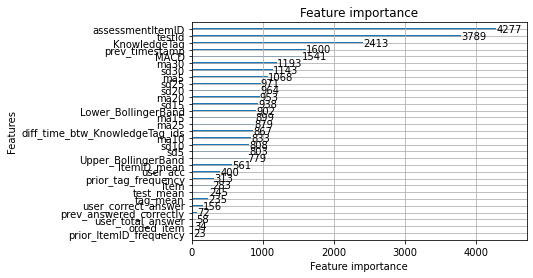

In [17]:
model = lgb.train(
                    {'objective': 'binary'}, 
                    lgb_train,
                    valid_sets=[lgb_train, lgb_test],
                    verbose_eval=100,
                    num_boost_round=1000,
                    early_stopping_rounds=100,
                    categorical_feature=categorical_features
                )

preds = model.predict(test[FEATS])
acc = accuracy_score(test_answer, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(test_answer, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')
lgb.plot_importance(model)

# inference

In [255]:
# MAKE PREDICTION
df_test_shift = df_test[df_test['userID'] != df_test['userID'].shift(-1)] # 맞춰야하는 row만 모아놓은 것

total_preds = model.predict(df_test_shift[FEATS])
# SAVE OUTPUT
output_dir = './'
prediction_name = datetime.now(timezone(timedelta(hours=9))).strftime('%m%d_%H%M')

write_path = os.path.join(output_dir, f"{prediction_name}.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)    
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : ./0608_1741.csv
